In [70]:
import psi4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg as splinalg


# Hartree-Fock problems
Think of H2 dissociating. 

**Near equilibrium rAB:** What do you expect bonding and antibonding orbitals to look like near the equilibrium distance? What would be lower energy, singlet or triplet? Why?

**rAB -> Infinity:** What do you expect bonding and antibonding orbitals to look like near the equilibrium distance? What would be lower energy, singlet or triplet? Why?


[0.4, 0.5, 0.75, 1, 1.5, 2, 4, 6]


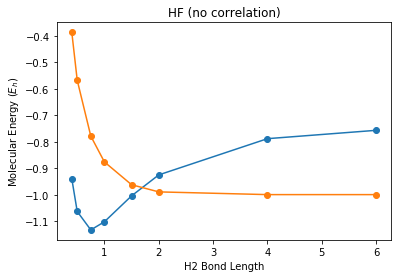

done


In [114]:
psi4.core.clean()

# ==> Compute H2 singlet and triplet energy with Hartree-Fock using Psi4 <==

#method
method = 'SCF'

#minimal basis to start
#basis = 'sto-3g'

#bigger basis takes a few seconds
basis = 'cc-pvtz'

# set computation options
psi4.set_options({'basis': basis,
                  'reference': 'rohf'})
#psi4.set_options({'basis': basis})


# singlet H2 has a charge of 0, spin multiplicity of 1 (m_s=0)
h2_singlet = """
0 1
H 
H 1 {}
"""

# triplet H2 has a charge of 0, spin multiplicity of 3 (m_s=1)
h2_triplet = """
0 3
H 
H 1 {}
"""

rAB_list = [0.4, 0.5, 0.75, 1, 1.5, 2, 4, 6]
print(rAB_list)

def scan(geom,rAB,method='SCF'):
    e = ['']*len(rAB)
    count = -1
    for rAB in rAB_list:
        #print(rAB)
        count = count+1
        mol = psi4.geometry(geom.format(rAB))
        e[count] = psi4.energy(method,molecule=mol)
    return e

e_singlet = scan(h2_singlet,rAB_list,method)
#print(e_singlet)

e_triplet = scan(h2_triplet,rAB_list,method)
#print(e_triplet)

psi4.core.clean()

# Visualize energy profile
x = rAB_list
y1 = e_singlet
y2 = e_triplet
plt.title('HF (no correlation)')
plt.plot(x,y1,'o-',x,y2,'-o')
plt.xlabel('H2 Bond Length')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

print('done')

# Static electron correlation in a 1D model


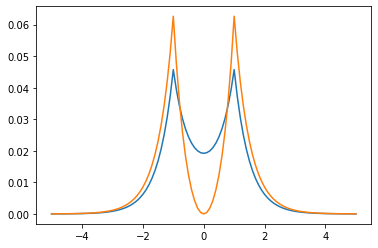

In [99]:
def psi1s(x,rN):
    return np.exp(-np.abs(x-rN))

x = np.array([i for i in range(-50,51)])/10
#print(x)

#neglecting overlap
c_sigma = np.array([1,1])/np.sqrt(2)
c_sigma_star = np.array([1,-1])/np.sqrt(2)

def mo(x,rN_array,c):
    rA = rN_array[0]
    rB = rN_array[1]
    cA = c[0]
    cB=c[1]
    out = cA*psi1s(x,rA)+cB*psi1s(x,rB)
    norm = np.sqrt(np.sum(out**2))
    return out/norm

rN_array= np.array([-1, 1])

uh = mo(x,rN_array,c_sigma)
plt.plot(x,uh**2)

uh = mo(x,rN_array,c_sigma_star)
plt.plot(x,uh**2)

In [106]:
r1 = x
r2 = x
R1, R2 = np.meshgrid(r1,r2)

Psi1 = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma)
Psi2 = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma_star)
Psi3 = mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma)
Psi4 = mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma_star)




(-5.0, 5.0, -5.0, 5.0)

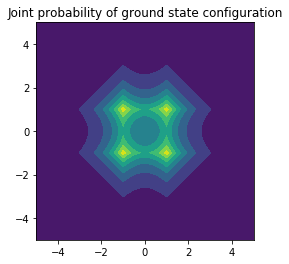

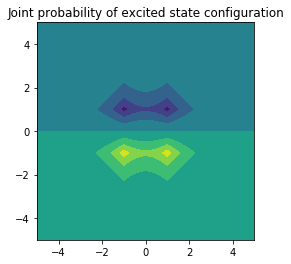

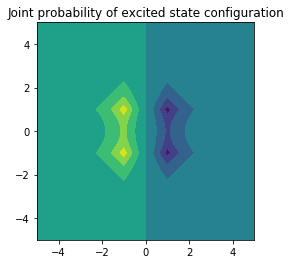

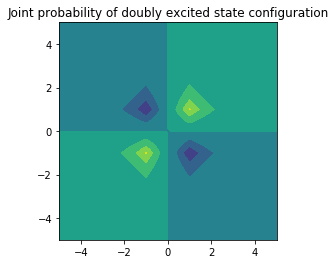

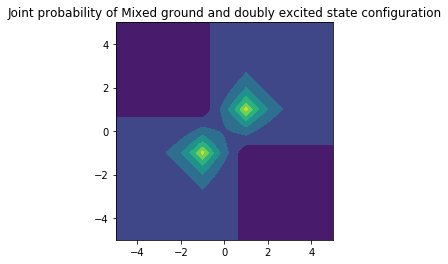

In [112]:
plt.contourf(R1,R2,Psi1)
plt.title('Joint probability of ground state configuration')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi2)
plt.title('Joint probability of excited state configuration')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi3)
plt.title('Joint probability of excited state configuration')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi4)
plt.title('Joint probability of doubly excited state configuration')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi1+Psi4)
plt.title('Joint probability of Mixed ground and doubly excited state configuration')
plt.axis('square')




# Configuration Interaction

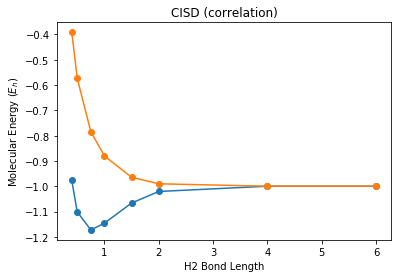

done


In [115]:
method = 'cisd'

e_singlet = scan(h2_singlet,rAB_list,method)
#print(e_singlet)

e_triplet = scan(h2_triplet,rAB_list,method)
#print(e_triplet)


# Visualize energy profile
x = rAB_list
y1 = e_singlet
y2 = e_triplet
plt.title('CISD (correlation)')
plt.plot(x,y1,'o-',x,y2,'-o')
plt.xlabel('H2 Bond Length')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

print('done')

Question: What is the energy difference at rAB-> infinity? Which is better description of H2, CIDS or HF?


# Trying to plot the wavefunction!!!! ARGH!

In [18]:
help(wfn)

Help on Wavefunction in module psi4.core object:

class Wavefunction(pybind11_builtins.pybind11_object)
 |  docstring
 |  
 |  Method resolution order:
 |      Wavefunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Ca(...)
 |      Ca(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Orbitals.
 |  
 |  Ca_subset(...)
 |      Ca_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Alpha Orbital subset.
 |  
 |  Cb(...)
 |      Cb(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Beta Orbitals.
 |  
 |  Cb_subset(...)
 |      Cb_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Beta Orbital subset.
 |  
 |  Da(...)
 |      Da(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Density Matrix.
 |  
 |

In [14]:
help( psi4.core.Wavefunction)

Help on class Wavefunction in module psi4.core:

class Wavefunction(pybind11_builtins.pybind11_object)
 |  docstring
 |  
 |  Method resolution order:
 |      Wavefunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Ca(...)
 |      Ca(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Orbitals.
 |  
 |  Ca_subset(...)
 |      Ca_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Alpha Orbital subset.
 |  
 |  Cb(...)
 |      Cb(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Beta Orbitals.
 |  
 |  Cb_subset(...)
 |      Cb_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Beta Orbital subset.
 |  
 |  Da(...)
 |      Da(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Density Matrix.
 |  
 | 

In [9]:
h2_singlet = """
0 1
H 
H 1 0.75
"""
#minimal basis
basis='sto-3g'

#bigger basis takes a few seconds
#basis = 'cc-pvtz'

# set computation options
psi4.set_options({'basis': basis,
                  'reference': 'rohf'})

mol = psi4.geometry(h2_singlet)
wfn=psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))

ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 


Number of occupied orbitals: 1
Number of basis functions: 2


In [19]:
# Construct a molecular integrals object
mints = psi4.core.MintsHelper(wfn.basisset())

# Overlap matrix as a psi4 Matrix object
S_matrix = mints.ao_overlap()

# Overlap matrix converted into an ndarray
S = np.asarray(S_matrix) 

print(F'Shape of S is {S.shape}')

Shape of S is (2, 2)


In [76]:
e,wfn_out=psi4.energy('SCF',molecule=mol,return_wfn='true')
print(e)
#wfn coeffs
Ca = wfn_out.Ca().to_array(dense='true')
Cb = wfn_out.Cb().to_array(dense='true')
#density matrices
Da = wfn_out.Da().to_array(dense='true')
Db = wfn_out.Db().to_array(dense='true')
#eigenvalues
epsilon_a = wfn_out.epsilon_a().to_array(dense='true')
epsilon_b = wfn_out.epsilon_b().to_array(dense='true')
aotoso = wfn_out.aotoso().to_array(dense='true')

print('coeffs')
print(Ca)
print(Cb)
print('densities')
print(Da)
print(Db)
print('eigenvalues')
print(epsilon_a)
print(epsilon_b)

#not sure
print(aotoso)
print(aotoso.dot(Ca))

#
S = wfn_out.S().to_array(dense='true')
print()

print(F'S=\n{S}')
A = splinalg.sqrtm(np.linalg.inv(S))
C=A.dot(Ca)
print(C)

# I think what I need is a way to "simply" evaluate the wavefunction amplitude as a function of r1 and r2. How can I do that?
#If I can do that I can plot the wavefunction amplitude (or square) on a grid over A and B

-1.1161753863221764
coeffs
[[0.77771366 0.        ]
 [0.         1.69841668]]
[[0.77771366 0.        ]
 [0.         1.69841668]]
densities
[[0.60483854 0.        ]
 [0.         0.        ]]
[[0.60483854 0.        ]
 [0.         0.        ]]
eigenvalues
[-0.5744605  0.6607249]
[-0.5744605  0.6607249]
[[ 0.70710678  0.        ]
 [ 0.70710678  0.        ]
 [ 0.          0.70710678]
 [ 0.         -0.70710678]]
[[ 0.5499266   0.        ]
 [ 0.5499266   0.        ]
 [ 0.          1.20096195]
 [ 0.         -1.20096195]]

S=
[[1.6533338 0.       ]
 [0.        0.3466662]]
[[0.60483854 0.        ]
 [0.         2.88461923]]


In [18]:
help(wfn)

Help on Wavefunction in module psi4.core object:

class Wavefunction(pybind11_builtins.pybind11_object)
 |  docstring
 |  
 |  Method resolution order:
 |      Wavefunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Ca(...)
 |      Ca(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Orbitals.
 |  
 |  Ca_subset(...)
 |      Ca_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Alpha Orbital subset.
 |  
 |  Cb(...)
 |      Cb(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Beta Orbitals.
 |  
 |  Cb_subset(...)
 |      Cb_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Beta Orbital subset.
 |  
 |  Da(...)
 |      Da(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Density Matrix.
 |  
 |

In [15]:
help(psi4.core.MintsHelper)

Help on class MintsHelper in module psi4.core:

class MintsHelper(pybind11_builtins.pybind11_object)
 |  Computes integrals
 |  
 |  Method resolution order:
 |      MintsHelper
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: psi4.core.MintsHelper, arg0: psi::BasisSet) -> None
 |      
 |      2. __init__(self: psi4.core.MintsHelper, arg0: psi::Wavefunction) -> None
 |  
 |  ao_3coverlap(...)
 |      ao_3coverlap(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. ao_3coverlap(self: psi4.core.MintsHelper) -> psi4.core.Matrix
 |      
 |      3 Center overlap integrals
 |      
 |      2. ao_3coverlap(self: psi4.core.MintsHelper, bs1: psi::BasisSet, bs2: psi::BasisSet, bs3: psi::BasisSet) -> psi4.core.Matrix
 |      
 |      3 Center overalp integrals
 |  
 |  ao_angular_momentum(...)
 |      ao_angular_mo

In [20]:
help(psi4.core)

Help on module psi4.core in psi4:

NAME
    psi4.core - C++ Innards of Psi4: Open-Source Quantum Chemistry

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        AOShellCombinationsIterator
        BSVec
        BasisExtents
        BasisFunctions
            PointFunctions
                RKSFunctions
                UKSFunctions
        BasisSet
        BlockOPoints
        CIVector
        CdSalc
        CdSalcList
        CharacterTable
        CorrelationFactor
            FittedSlaterCorrelationFactor
        CorrelationTable
        CubeProperties
        DFHelper
        DFTensor
        DIISManager
        Deriv
        DiagonalizeOrder
        Dimension
        Dispersion
        ERISieve
        ExternalPotential
        FCHKWriter
        FDDS_Dispersion
        FISAPT
        FittingMetric
        FragmentType
        Functional
            LibXCFunctional
        GaussianShell
        GaussianType
        GeometryUnits
        IO
        IOManager
       

In [23]:
wfn.p

AttributeError: 'psi4.core.Wavefunction' object has no attribute 'p'

In [26]:
help(psi4.core.MintsHelper)

Help on class MintsHelper in module psi4.core:

class MintsHelper(pybind11_builtins.pybind11_object)
 |  Computes integrals
 |  
 |  Method resolution order:
 |      MintsHelper
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: psi4.core.MintsHelper, arg0: psi::BasisSet) -> None
 |      
 |      2. __init__(self: psi4.core.MintsHelper, arg0: psi::Wavefunction) -> None
 |  
 |  ao_3coverlap(...)
 |      ao_3coverlap(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. ao_3coverlap(self: psi4.core.MintsHelper) -> psi4.core.Matrix
 |      
 |      3 Center overlap integrals
 |      
 |      2. ao_3coverlap(self: psi4.core.MintsHelper, bs1: psi::BasisSet, bs2: psi::BasisSet, bs3: psi::BasisSet) -> psi4.core.Matrix
 |      
 |      3 Center overalp integrals
 |  
 |  ao_angular_momentum(...)
 |      ao_angular_mo

In [34]:
mints = psi4.core.MintsHelper(wfn)
np.asarray(mints.ao_overlap())

array([[1.       , 0.6533338],
       [0.6533338, 1.       ]])

In [36]:

help(psi4.energy)

Help on function energy in module psi4.driver.driver:

energy(name, **kwargs)
    Function to compute the single-point electronic energy.
    
    :returns: *float* |w--w| Total electronic energy in Hartrees. SAPT & EFP return interaction energy.
    
    :returns: (*float*, :py:class:`~psi4.core.Wavefunction`) |w--w| energy and wavefunction when **return_wfn** specified.
    
    :PSI variables:
    
    .. hlist::
       :columns: 1
    
       * :psivar:`CURRENT ENERGY <CURRENTENERGY>`
       * :psivar:`CURRENT REFERENCE ENERGY <CURRENTREFERENCEENERGY>`
       * :psivar:`CURRENT CORRELATION ENERGY <CURRENTCORRELATIONENERGY>`
    
    :type name: string
    :param name: ``'scf'`` || ``'mp2'`` || ``'ci5'`` || etc.
    
        First argument, usually unlabeled. Indicates the computational method
        to be applied to the system.
    
    :type molecule: :ref:`molecule <op_py_molecule>`
    :param molecule: ``h2o`` || etc.
    
        The target molecule, if not the last molecule d

In [51]:
help(psi4.core.Matrix)

Help on class Matrix in module psi4.core:

class Matrix(pybind11_builtins.pybind11_object)
 |  Class for creating and manipulating matrices
 |  
 |  Method resolution order:
 |      Matrix
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__ = _irrep_access(self, *args, **kwargs)
 |      Warns user when iterating/accessing an irreped object.
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: psi4.core.Matrix, arg0: int, arg1: int) -> None
 |      
 |      2. __init__(self: psi4.core.Matrix, arg0: str, arg1: int, arg2: int) -> None
 |      
 |      3. __init__(self: psi4.core.Matrix, arg0: str, arg1: psi4.core.Dimension, arg2: psi4.core.Dimension) -> None
 |      
 |      4. __init__(self: psi4.core.Matrix, arg0: str, arg1: psi4.core.Dimension, arg2: psi4.core.Dimension, arg3: int) -> None
 |      
 |      5. __init__(self: psi4.core.Matrix, arg0: str) -

In [77]:
help(psi4.core.BasisSet
    )

Help on class BasisSet in module psi4.core:

class BasisSet(pybind11_builtins.pybind11_object)
 |  Contains basis set information
 |  
 |  Method resolution order:
 |      BasisSet
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: psi4.core.BasisSet, arg0: str, arg1: psi4.core.Molecule, arg2: Dict[str, Dict[str, List[psi4.core.ShellInfo]]], arg3: Dict[str, Dict[str, List[psi4.core.ShellInfo]]]) -> None
 |  
 |  ao_to_shell(...)
 |      ao_to_shell(self: psi4.core.BasisSet, i: int) -> int
 |      
 |      Given a cartesian function (AO) number what shell does it correspond to
 |  
 |  blend(...)
 |      blend(self: psi4.core.BasisSet) -> str
 |      
 |      Plus-separated string of [basisname] values
 |  
 |  ecp_shell(...)
 |      ecp_shell(self: psi4.core.BasisSet, si: int) -> psi4.core.GaussianShell
 |      
 |      Return the si'th ECP shell
 |  
 |  ecp_shell_on_center(...)
 |      ecp_she

In [78]:
help(psi4.core.MolecularGrid)

Help on class MolecularGrid in module psi4.core:

class MolecularGrid(pybind11_builtins.pybind11_object)
 |  docstring
 |  
 |  Method resolution order:
 |      MolecularGrid
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  blocks(...)
 |      blocks(self: psi4.core.MolecularGrid) -> List[psi4.core.BlockOPoints]
 |      
 |      Returns a list of blocks.
 |  
 |  collocation_size(...)
 |      collocation_size(self: psi4.core.MolecularGrid) -> int
 |      
 |      Returns the total collocation size of all blocks.
 |  
 |  max_functions(...)
 |      max_functions(self: psi4.core.MolecularGrid) -> int
 |      
 |      Returns the maximum number of functions in a block.
 |  
 |  max_points(...)
 |      max_points(self: psi4.core.MolecularGrid) -> int
 |      
 |      Returns the maximum number of points in a block.
 |  


In [79]:
help(psi4.cubeprop)

Help on function cubeprop in module psi4.driver.p4util.util:

cubeprop(wfn, **kwargs)
    Evaluate properties on a grid and generate cube files.
    
    .. versionadded:: 0.5
       *wfn* parameter passed explicitly
    
    :returns: None
    
    :type wfn: :py:class:`~psi4.core.Wavefunction`
    :param wfn: set of molecule, basis, orbitals from which to generate cube files
    
    :examples:
    
    >>> # [1] Cube files for all orbitals
    >>> E, wfn = energy('b3lyp', return_wfn=True)
    >>> cubeprop(wfn)
    
    >>> # [2] Cube files for density (alpha, beta, total, spin) and four orbitals
    >>> #     (two alpha, two beta)
    >>> set cubeprop_tasks ['orbitals', 'density']
    >>> set cubeprop_orbitals [5, 6, -5, -6]
    >>> E, wfn = energy('scf', return_wfn=True)
    >>> cubeprop(wfn)



In [113]:
help()

Help on function oeprop in module psi4.driver.p4util.util:

oeprop(wfn, *args, **kwargs)
    Evaluate one-electron properties.
    
    :returns: None
    
    :type wfn: :py:class:`~psi4.core.Wavefunction`
    :param wfn: set of molecule, basis, orbitals from which to compute properties
    
    How to specify args, which are actually the most important
    
    :type title: string
    :param title: label prepended to all psivars computed
    
    :examples:
    
    >>> # [1] Moments with specific label
    >>> E, wfn = energy('hf', return_wfn=True)
    >>> oeprop(wfn, 'DIPOLE', 'QUADRUPOLE', title='H3O+ SCF')



In [18]:
help(wfn)

Help on Wavefunction in module psi4.core object:

class Wavefunction(pybind11_builtins.pybind11_object)
 |  docstring
 |  
 |  Method resolution order:
 |      Wavefunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Ca(...)
 |      Ca(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Orbitals.
 |  
 |  Ca_subset(...)
 |      Ca_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Alpha Orbital subset.
 |  
 |  Cb(...)
 |      Cb(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Beta Orbitals.
 |  
 |  Cb_subset(...)
 |      Cb_subset(self: psi4.core.Wavefunction, arg0: str, arg1: str) -> psi4.core.Matrix
 |      
 |      Returns the requested Beta Orbital subset.
 |  
 |  Da(...)
 |      Da(self: psi4.core.Wavefunction) -> psi4.core.Matrix
 |      
 |      Returns the Alpha Density Matrix.
 |  
 |